linear regression
- simple statistcal golem that learn means and variance of measurement

In [1]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import BSpline
from scipy.stats import gaussian_kde

import jax.numpy as jnp
from jax import random, vmap

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(
    category.__name__, message
)
az.style.use("arviz-darkgrid")

In [2]:
pos = jnp.sum(dist.Uniform(-1,1).sample(
    random.PRNGKey(0), (1000,16)), -1
)

(array([  3.,  33.,  68., 121., 215., 243., 160., 109.,  41.,   7.]),
 array([-7.241252 , -5.8748493, -4.508447 , -3.1420448, -1.7756424,
        -0.40924  ,  0.9571624,  2.3235648,  3.6899672,  5.05637  ,
         6.422772 ], dtype=float32),
 <BarContainer object of 10 artists>)

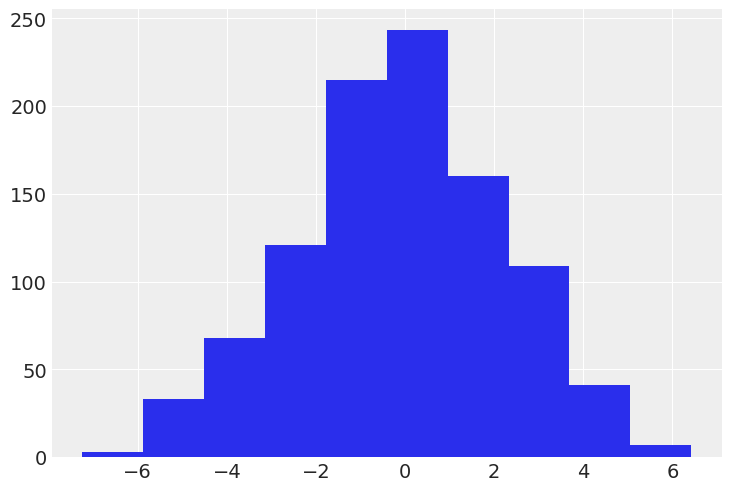

In [15]:
plt.hist(pos)

In [17]:
jnp.prod(1 + dist.Uniform(0, 0.1).sample(random.PRNGKey(0), (1000,12)))

DeviceArray(inf, dtype=float32)

In [18]:
growth = jnp.prod(1 + dist.Uniform(0, 0.1).sample(random.PRNGKey(0), (1000, 12)), -1)

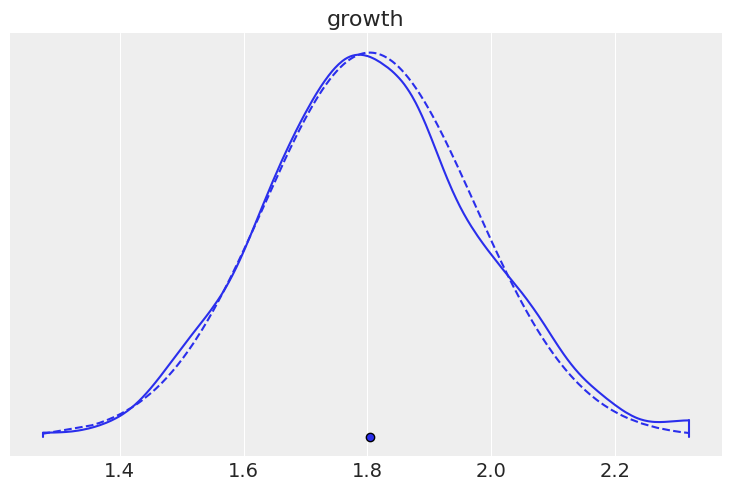

In [21]:
az.plot_density({"growth": growth}, hdi_prob=1)
x = jnp.sort(growth)
plt.plot(x, jnp.exp(dist.Normal(jnp.mean(x), jnp.std(x)).log_prob(x)), "--")
plt.show()

In [22]:
big = jnp.log(
    jnp.prod(1 + dist.Uniform(0,0.5 ).sample(
        random.PRNGKey(0), ( 1000, 12)
    ), -1)
)

In [24]:
small= jnp.log(
    jnp.prod(1 + dist.Uniform(0,0.1 ).sample(
        random.PRNGKey(0), ( 1000, 12)
    ), -1)
)

Ontological justification 
- world is full of gaussian
- never experience perfect one, but is a wide spread pattern
- con is it can not identify micro-process

Epistemological justification
- most natural expression of our state of ignorance
- we assume some finite variance

Gaussian

$$

p(y|\mu,\sigma) = \frac{1}{\sqrt{2\pi\sigma^{2}}}exp(-\frac{(y-\mu)^{2}} {2\sigma^{2}})
$$

Gaussian is continuous distribtion.
Binomial is discrete.


Language to understand:

$$
y_{i} \sim Normal(\mu_{i}, \sigma) \\
\
\mu_{i} = \beta x_{i} \\

\beta \sim Normal(0, 10) \\

\mu \sim Exponential(1) \\

x_{i} \sim Normal(0, 1)
$$

In [32]:
w = 6
n = 9

p_grid = jnp.linspace(start=0, stop=1, num=100)
prob_binom = jnp.exp(dist.Binomial(n, p_grid).log_prob(w))
posterior = prob_binom * jnp.exp(dist.Uniform(0, 1).log_prob(p_grid))
posterior = posterior/jnp.sum(posterior)

In [36]:
df = pd.read_csv('Howell1.csv', sep=';')

In [37]:
df.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041914  41.0     1
4  145.415  41.276872  51.0     0

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  544 non-null    float64
 1   weight  544 non-null    float64
 2   age     544 non-null    float64
 3   male    544 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


In [40]:
print_summary(dict(zip(df.columns, df.T.values)), 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
       age     29.34     20.75     27.00      0.00     57.00    186.38      1.03
    height    138.26     27.60    148.59     90.81    170.18    218.68      1.06
      male      0.47      0.50      0.00      0.00      1.00    670.75      1.00
    weight     35.61     14.72     40.06     11.37     55.71    305.62      1.05



In [42]:
df.height.head()

0    151.765
1    139.700
2    136.525
3    156.845
4    145.415
Name: height, dtype: float64

In [43]:
d2 = df[df.age >= 18]

In [44]:
d2.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041914  41.0     1
4  145.415  41.276872  51.0     0

(array([ 8., 32., 62., 60., 65., 65., 35., 18.,  6.,  1.]),
 array([136.525 , 140.7795, 145.034 , 149.2885, 153.543 , 157.7975,
        162.052 , 166.3065, 170.561 , 174.8155, 179.07  ]),
 <BarContainer object of 10 artists>)

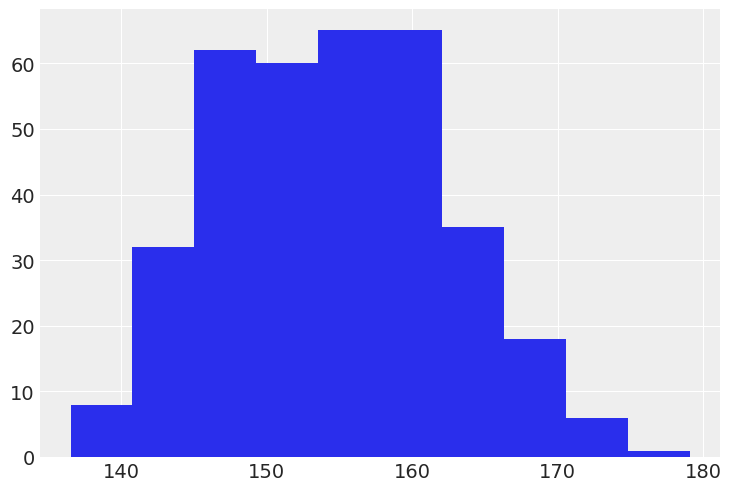

In [45]:
plt.hist(d2.height)

Only do gaussian if it looks gaussin to u

$$
h_{i} \sim Normal(\mu, \sigma) \\

h_{i} \sim N(\mu, \sigma)

$$

i means each individual
h means height

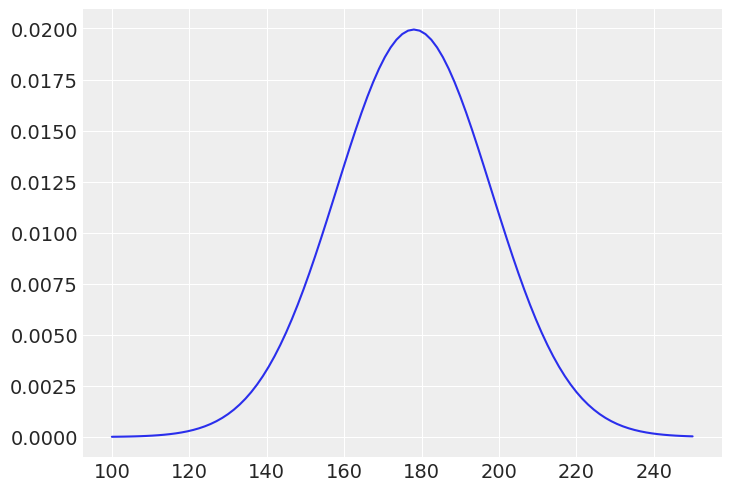

In [51]:
x = jnp.linspace(100, 250, 101)
plt.plot(x, jnp.exp(dist.Normal(178, 20).log_prob(x)))

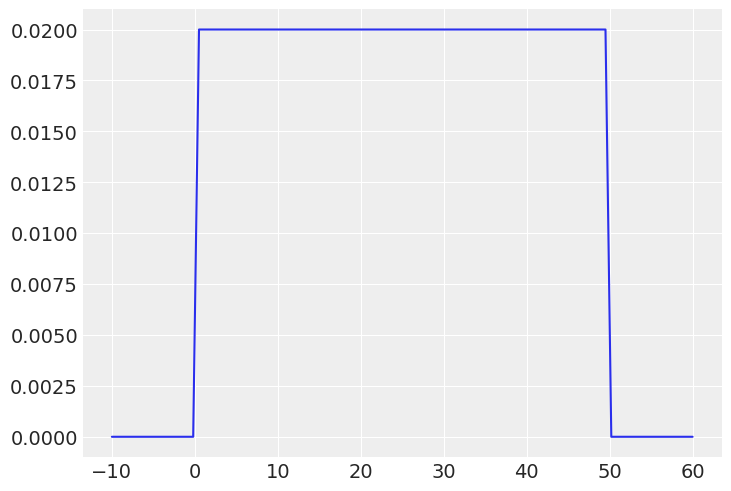

In [53]:
x = jnp.linspace(-10, 60, 101)
plt.plot(x, jnp.exp(dist.Uniform(0, 50, validate_args=True).log_prob(x)))

In [65]:
sample_mu = dist.Normal(178, 20).sample(
    random.PRNGKey(0), (int(1e4),)
)
sample_sigma = dist.Uniform(0, 50).sample(
    random.PRNGKey(1), (int(1e4),)
)

prior_h = dist.Normal(sample_mu, sample_sigma).sample(
    random.PRNGKey(2))


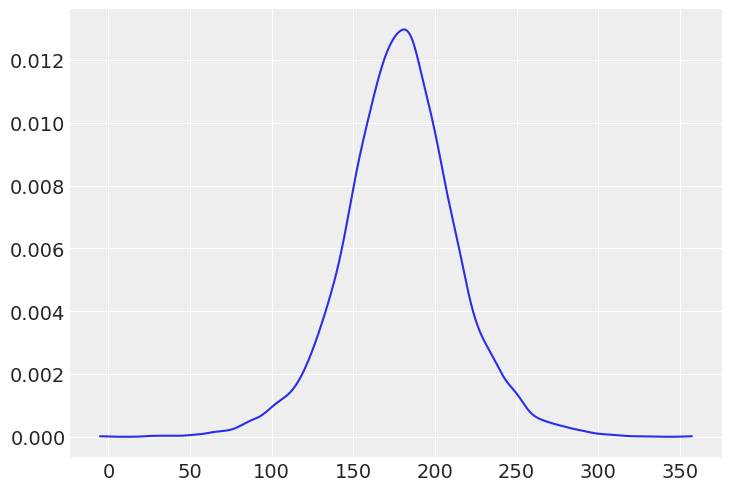

In [66]:
az.plot_kde(prior_h)
plt.show()

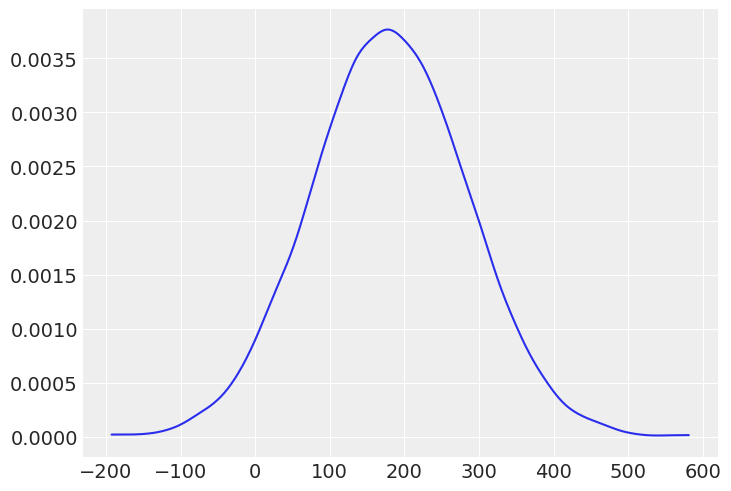

In [67]:
sample_mu = dist.Normal(178, 100).sample(
    random.PRNGKey(0), (int(1e4),)
)

prior_h = dist.Normal(sample_mu, sample_sigma).sample(
    random.PRNGKey(2))
az.plot_kde(prior_h)
plt.show()


In [70]:
mu_list = jnp.linspace(start=150, stop=160, num=100)
sigma_list = jnp.linspace(start=7, stop=9, num=100)
mesh = jnp.meshgrid(mu_list, sigma_list)
post = {"mu": mesh[0].reshape(-1), "sigma": mesh[1].reshape(-1)}
post["LL"] = vmap(
    lambda mu, sigma: jnp.sum(dist.Normal(mu, sigma).log_prob(d2.height.values))
)(post["mu"], post["sigma"])
logprob_mu = dist.Normal(178, 20).log_prob(post["mu"])
logprob_sigma = dist.Uniform(0, 50).log_prob(post["sigma"])
post["prob"] = post["LL"] + logprob_mu + logprob_sigma
post["prob"] = jnp.exp(post["prob"] - jnp.max(post["prob"]))

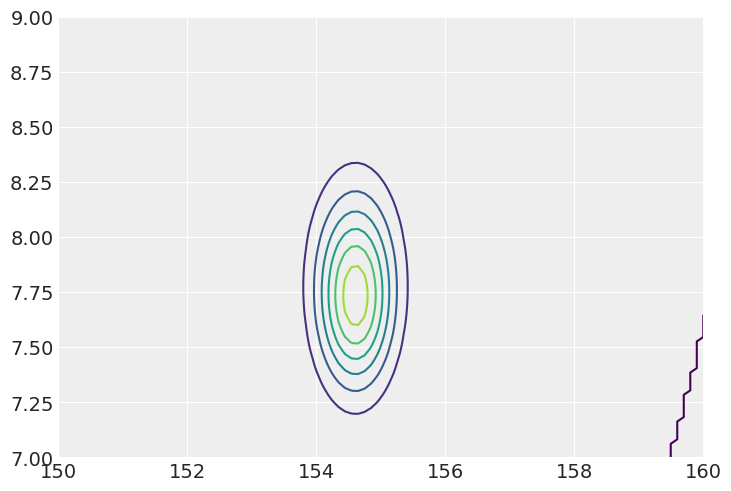

In [71]:
plt.contour(
    post["mu"].reshape(100, 100),
    post["sigma"].reshape(100, 100),
    post["prob"].reshape(100, 100),
)
plt.show()

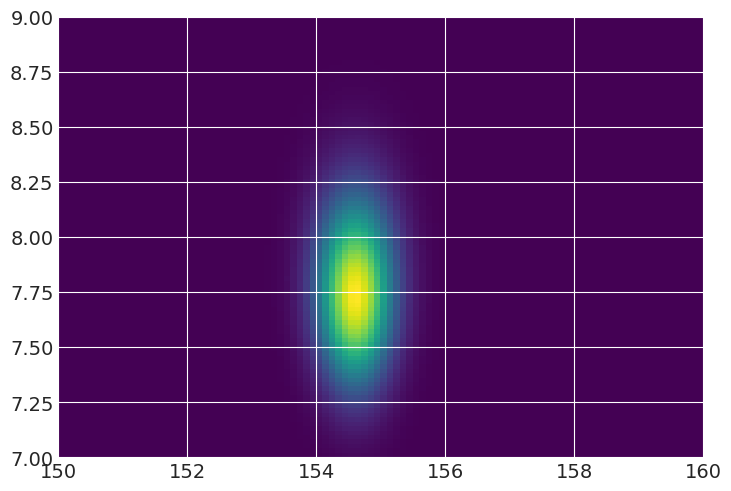

In [72]:
plt.imshow(
    post["prob"].reshape(100, 100),
    origin="lower",
    extent=(150, 160, 7, 9),
    aspect="auto",
)
plt.show()

In [73]:
prob = post["prob"] / jnp.sum(post["prob"])
sample_rows = dist.Categorical(probs=prob).sample(random.PRNGKey(0), (int(1e4),))
sample_mu = post["mu"][sample_rows]
sample_sigma = post["sigma"][sample_rows]

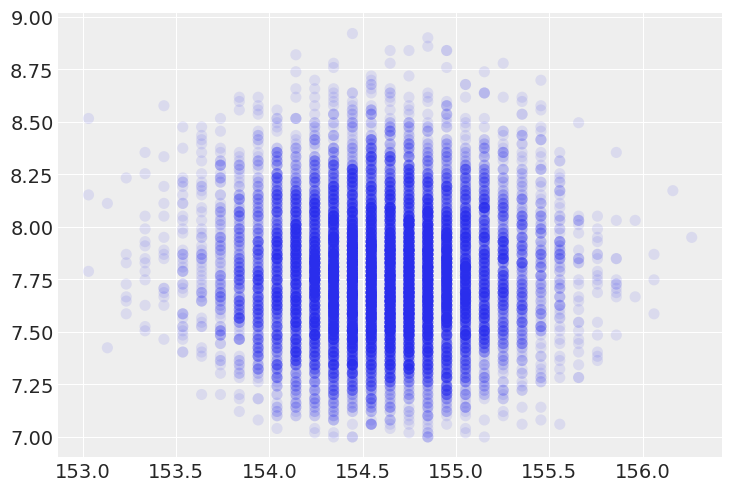

In [76]:
plt.scatter(sample_mu, sample_sigma, s=64, alpha=0.1, edgecolor="none")
plt.show()

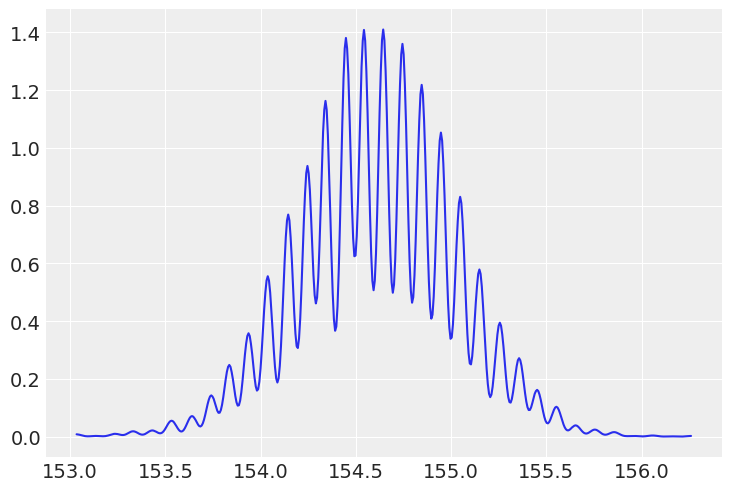

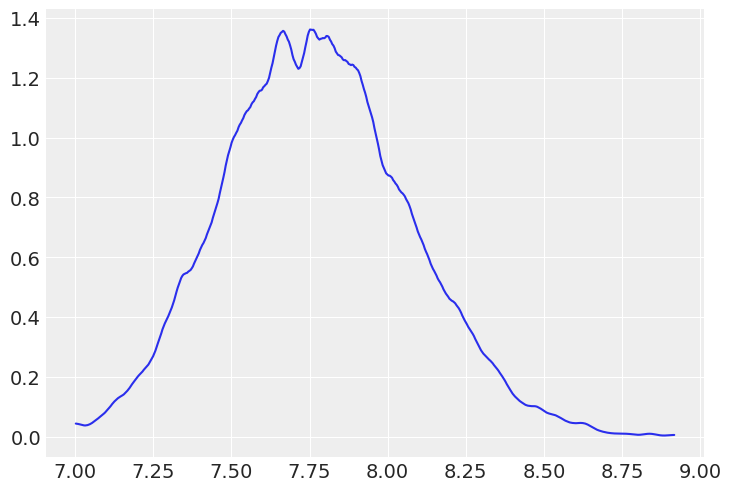

In [77]:
az.plot_kde(sample_mu)
plt.show()
az.plot_kde(sample_sigma)
plt.show()

In [78]:
print(hpdi(sample_mu, 0.89))
print(hpdi(sample_sigma, 0.89))

[153.93939 155.15152]
[7.3232327 8.252525 ]


In [79]:
d3 = d2.height.sample(n=20)

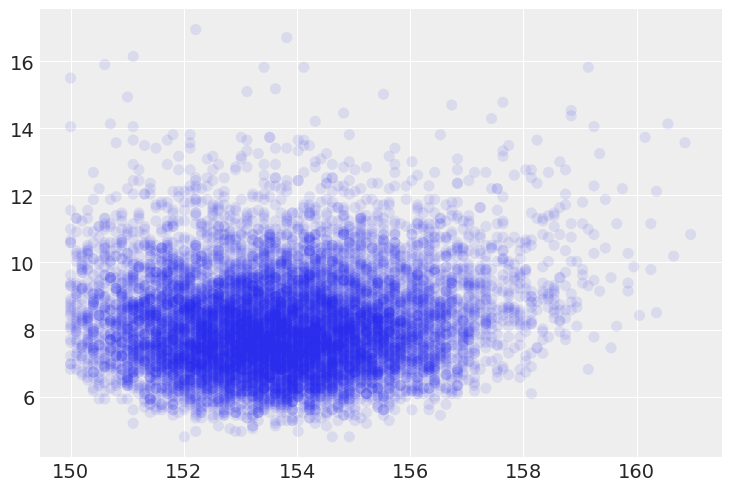

In [81]:
mu_list = jnp.linspace(start=150, stop=170, num=200)
sigma_list = jnp.linspace(start=4, stop=20, num=200)
mesh = jnp.meshgrid(mu_list, sigma_list)
post2 = {"mu": mesh[0].reshape(-1), "sigma": mesh[1].reshape(-1)}
post2["LL"] = vmap(
    lambda mu, sigma: jnp.sum(dist.Normal(mu, sigma).log_prob(d3.values))
)(post2["mu"], post2["sigma"])
logprob_mu = dist.Normal(178, 20).log_prob(post2["mu"])
logprob_sigma = dist.Uniform(0, 50).log_prob(post2["sigma"])
post2["prob"] = post2["LL"] + logprob_mu + logprob_sigma
post2["prob"] = jnp.exp(post2["prob"] - jnp.max(post2["prob"]))
prob = post2["prob"] / jnp.sum(post2["prob"])
sample2_rows = dist.Categorical(probs=prob).sample(random.PRNGKey(0), (int(1e4),))
sample2_mu = post2["mu"][sample2_rows]
sample2_sigma = post2["sigma"][sample2_rows]
plt.scatter(sample2_mu, sample2_sigma, s=64, alpha=0.1, edgecolor="none")
plt.show()

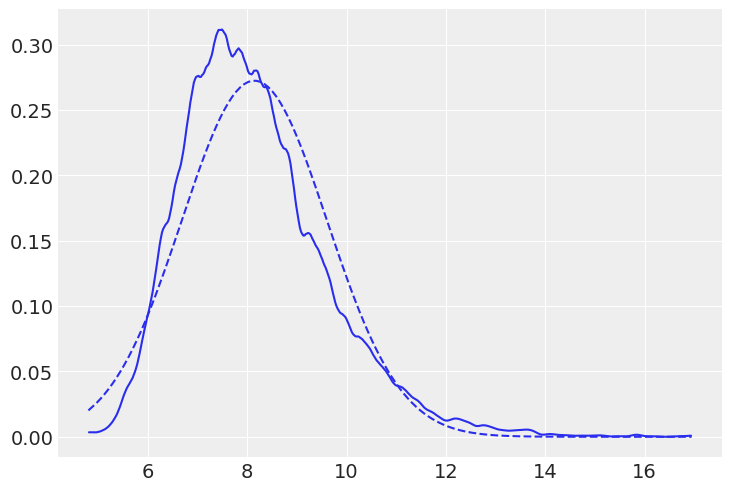

In [82]:
az.plot_kde(sample2_sigma)
x = jnp.sort(sample2_sigma)
plt.plot(x, jnp.exp(dist.Normal(jnp.mean(x), jnp.std(x)).log_prob(x)), "--")
plt.show()

Quadratic Approxiamtion 
- posterior peak usually lies in the MAP(maximum a posteriori)
- we can get a good shape by quaratic approximiate the posterior distribution of the pewak



In [85]:
d = pd.read_csv('Howell1.csv', ';')

In [86]:
d2 = d[d.age>18]

In [87]:
d2.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041914  41.0     1
4  145.415  41.276872  51.0     0

$$
h \sim Norma(\mu, \sigma) \\
\mu \sim Normal(178, 20) \\
\sigma \sim Uniform(0, 50)
$$

In [88]:
def flist(height):
    mu = numpyro.sample("mu", dist.Normal(178, 20))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

m4_1 = AutoLaplaceApproximation(flist)
svi = SVI(flist, m4_1, optim.Adam(1), Trace_ELBO(), height=d2.height.values)
p4_1, losses = svi.run(random.PRNGKey(0), 2000)

In [91]:
m4_1 = AutoLaplaceApproximation(flist)
svi = SVI(flist, m4_1, optim.Adam(1), Trace_ELBO(), height=d2.height.values)
p4_1, losses = svi.run(random.PRNGKey(0), 2000)

100%|██████████| 2000/2000 [00:02<00:00, 687.42it/s, init loss: 3934.1401, avg. loss [1901-2000]: 1206.6323] 


In [93]:
samples = m4_1.sample_posterior(random.PRNGKey(0), p4_1, (1000,))
print_summary(samples, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
        mu    154.65      0.41    154.65    153.96    155.25   1057.91      1.00
     sigma      7.77      0.30      7.75      7.24      8.20    999.24      1.00



89 is used because it's just teh default -- of a prime number

quap works like climbing a hill. it starts climbing sompelace, at some combinatons of parametr value. unless you tell it other wise, it would start at random value from the prior

In [94]:
start = {"mu": d2.height.mean(), "sigma": d2.height.std()}
m4_1 = AutoLaplaceApproximation(flist, init_loc_fn=init_to_value(values=start))
svi = SVI(flist, m4_1, optim.Adam(0.1), Trace_ELBO(), height=d2.height.values)
p4_1, losses = svi.run(random.PRNGKey(0), 2000)

100%|██████████| 2000/2000 [00:01<00:00, 1055.52it/s, init loss: 1206.6317, avg. loss [1901-2000]: 1206.6323]


In [95]:
samples = m4_1.sample_posterior(random.PRNGKey(0), p4_1, (1000,))
print_summary(samples, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
        mu    154.65      0.41    154.65    153.96    155.25   1057.91      1.00
     sigma      7.77      0.30      7.75      7.24      8.20    999.24      1.00



In [96]:
def flist(height):
    mu = numpyro.sample("mu", dist.Normal(178, 0.1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)
    
m4_2 = AutoLaplaceApproximation(flist)
svi = SVI(flist, m4_2, optim.Adam(1), Trace_ELBO(), height=d2.height.values)
p4_2, losses = svi.run(random.PRNGKey(0), 2000)

100%|██████████| 2000/2000 [00:02<00:00, 821.67it/s, init loss: 1584127.6250, avg. loss [1901-2000]: 1598.3765] 


In [99]:
samples = m4_2.sample_posterior(random.PRNGKey(0), p4_2, (1000,))
print_summary(samples, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
        mu    177.86      0.10    177.86    177.70    178.01   1057.91      1.00
     sigma     24.47      0.96     24.42     22.79     25.84    989.09      1.00



In [100]:
samples = m4_1.sample_posterior(random.PRNGKey(1), p4_1, (1000,))
vcov = jnp.cov(jnp.stack(list(samples.values()), axis=0))
vcov

DeviceArray([[0.16664666, 0.00172997],
             [0.00172997, 0.08957577]], dtype=float32)

In [103]:

print(jnp.diagonal(vcov))
print(vcov / jnp.sqrt(jnp.outer(jnp.diagonal(vcov), jnp.diagonal(vcov))))

[0.16664666 0.08957577]
[[1.         0.01415941]
 [0.01415941 1.        ]]


In [104]:
post = m4_1.sample_posterior(random.PRNGKey(1), p4_1, (int(1e4),))
{latent: list(post[latent][:6]) for latent in post}

{'mu': [154.28493, 154.52911, 155.02913, 154.25266, 155.54788, 154.87505],
 'sigma': [7.5888405, 7.3320785, 7.3053336, 7.843557, 7.938254, 8.012399]}

In [109]:
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
        mu    154.66      0.42    154.65    153.97    155.30   9926.99      1.00
     sigma      7.78      0.30      7.77      7.30      8.25   9502.44      1.00



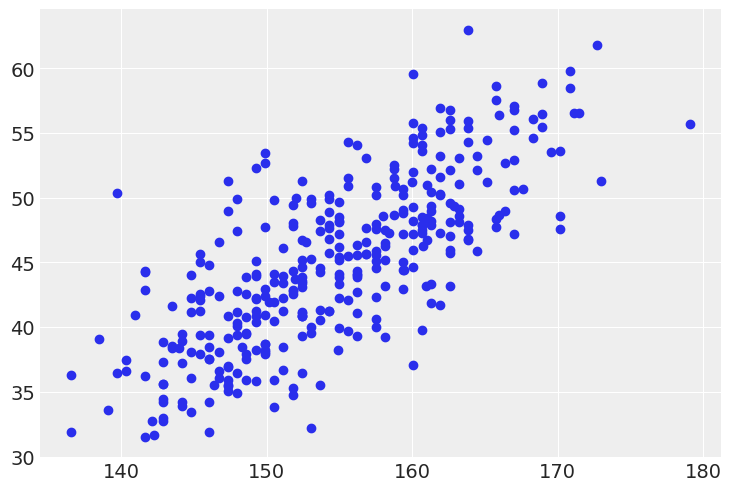

In [115]:
plt.scatter(d2.height, d2.weight)

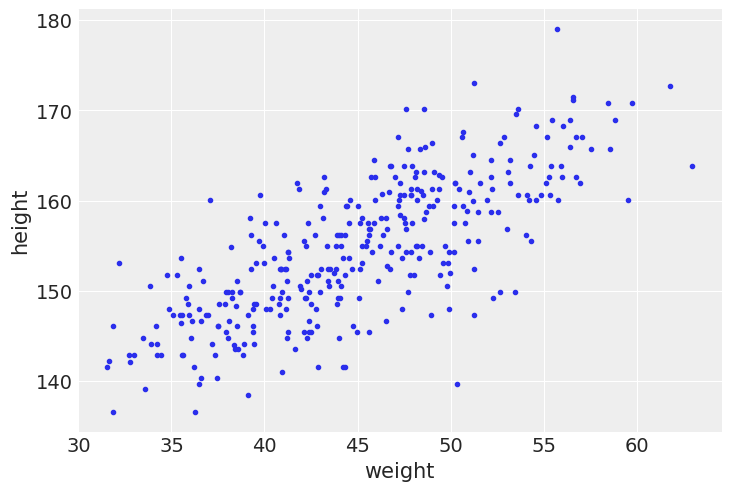

In [116]:
az.plot_pair(d2[["weight", "height"]].to_dict(orient="list"))
plt.show()

$$
h_{i} \sim Normal(\mu_{i}, \sigma) \\ 
\mu_{i} = \alpha + \beta(x_{i} - \bar{x}) \\
\alpha \sim Normal(178, 20) \\
\beta \sim Normal(0,10) \\
\sigma \sim Uniform(0, 50)

$$

likelihood

linear model

alpha prior

beta prior

sigma prior 

In [118]:
with numpyro.handlers.seed(rng_seed=2971):
    N = 100
    a = numpyro.sample("a", dist.Normal(178, 20).expand([N]))
    b = numpyro.sample("b", dist.Normal(0, 10).expand([N]))

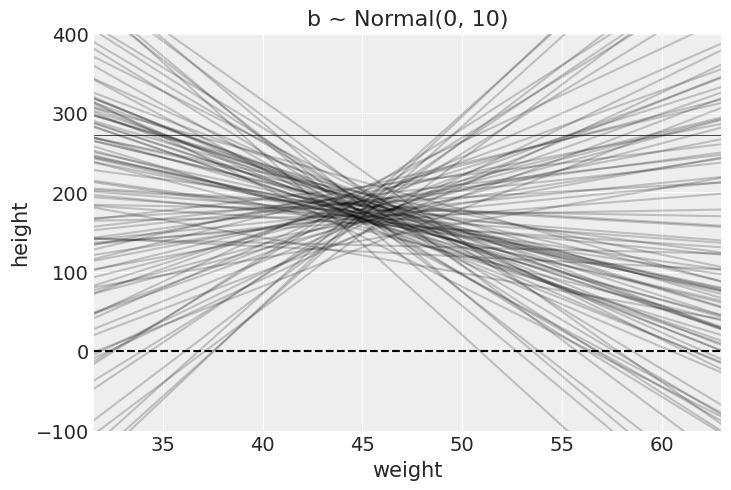

In [122]:
plt.subplot(
    xlim=(d2.weight.min(), d2.weight.max()),
    ylim=(-100, 400),
    xlabel="weight",
    ylabel="height",
)
plt.axhline(y=0, c="k", ls="--")
plt.axhline(y=272, c="k", ls="-", lw=0.5)
plt.title("b ~ Normal(0, 10)")
xbar = d2.weight.mean()
x = jnp.linspace(d2.weight.min(), d2.weight.max(), 101)
for i in range(N):
    plt.plot(x, a[i] + b[i] * (x - xbar), "k", alpha=0.2)
plt.show()

$$
Log normal is \\

\beta \sim Log-Normal(0,1)
$$

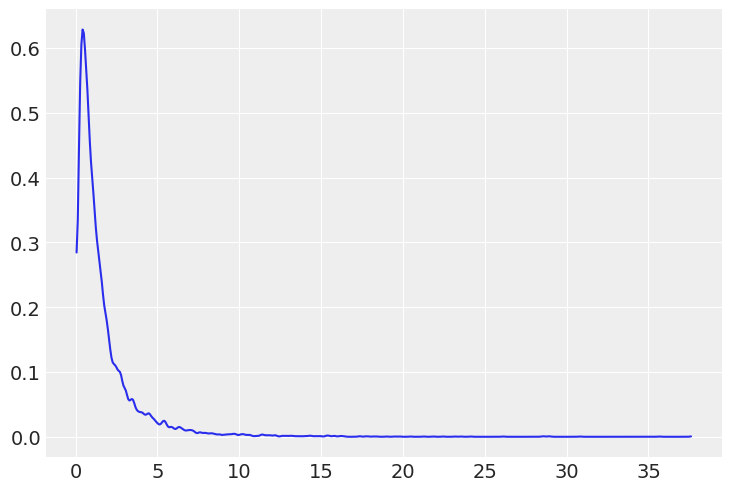

In [123]:

b = dist.LogNormal(0, 1).sample(random.PRNGKey(0), (int(1e4),))
az.plot_kde(b)
plt.show()

In [124]:
with numpyro.handlers.seed(rng_seed=2971):
    N = 100  # 100 lines
    a = numpyro.sample("a", dist.Normal(178, 28).expand([N]))
    b = numpyro.sample("b", dist.LogNormal(0, 1).expand([N]))

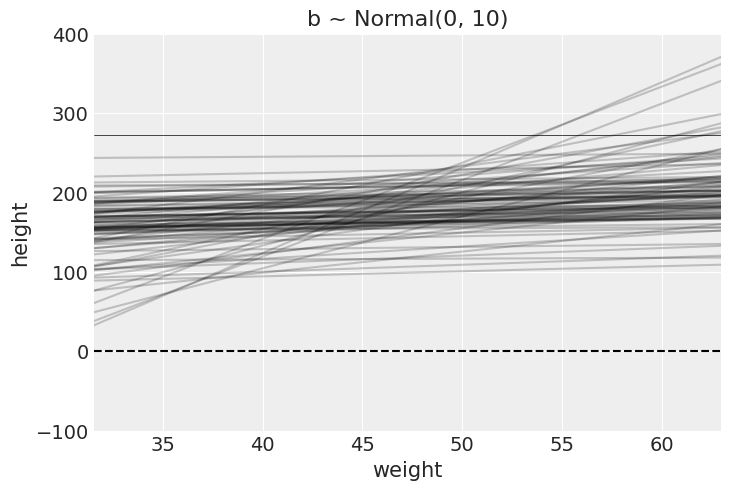

In [125]:
plt.subplot(
    xlim=(d2.weight.min(), d2.weight.max()),
    ylim=(-100, 400),
    xlabel="weight",
    ylabel="height",
)
plt.axhline(y=0, c="k", ls="--")
plt.axhline(y=272, c="k", ls="-", lw=0.5)
plt.title("b ~ Normal(0, 10)")
xbar = d2.weight.mean()
x = jnp.linspace(d2.weight.min(), d2.weight.max(), 101)
for i in range(N):
    plt.plot(x, a[i] + b[i] * (x - xbar), "k", alpha=0.2)
plt.show()

How to choose prior?
Prior encodes states of the information before seeing data.
So prior allows exploration of consequences of beginning with different information.

Convensional Bayesian priors are conservatives. 

In [126]:
xbar = d2.weight.mean()

In [128]:
# load data again, since it's a long way back
Howell1 = pd.read_csv("Howell1.csv", sep=";")
d = Howell1
d2 = d[d["age"] >= 18]

# define the average weight, x-bar
xbar = d2.weight.mean()

# fit model
def model(weight, height):
    # sampled, normal
    a = numpyro.sample("a", dist.Normal(178, 20))
    # sampled, log normal
    b = numpyro.sample("b", dist.LogNormal(0, 1))
    # sigma, uniform
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    # deterministic
    mu = numpyro.deterministic("mu", a + b * (weight - xbar))
    # result posterioro 
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


m4_3 = AutoLaplaceApproximation(model)
svi = SVI(
    model, m4_3, optim.Adam(1), Trace_ELBO(), weight=d2.weight.values, height=d2.height.values
)
p4_3, losses = svi.run(random.PRNGKey(0), 2000)

100%|██████████| 2000/2000 [00:02<00:00, 791.54it/s, init loss: 40631.5391, avg. loss [1901-2000]: 1078.9297] 


In [129]:
def model(weight, height=None):
    a = numpyro.sample("a", dist.Normal(178, 20))
    log_b = numpyro.sample("log_b", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", a + jnp.exp(log_b) * (weight - xbar))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


m4_3b = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m4_3b,
    optim.Adam(1),
    Trace_ELBO(),
    weight=d2.weight.values,
    height=d2.height.values,
)
p4_3b, losses = svi.run(random.PRNGKey(0), 2000)

100%|██████████| 2000/2000 [00:02<00:00, 718.67it/s, init loss: 40631.5391, avg. loss [1901-2000]: 1078.9297] 


In [133]:
samples = m4_3.sample_posterior(random.PRNGKey(0), p4_3, (1000,))
samples.pop("mu")
print_summary(samples, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a    154.60      0.28    154.60    154.19    155.05   1143.46      1.00
         b      0.91      0.04      0.91      0.83      0.96   1002.49      1.00
     sigma      5.06      0.19      5.06      4.75      5.37    990.79      1.00



In [134]:
vcov = jnp.cov(jnp.stack(list(samples.values()), axis=0))
jnp.round(vcov, 3)

DeviceArray([[0.076, 0.   , 0.001],
             [0.   , 0.002, 0.   ],
             [0.001, 0.   , 0.038]], dtype=float32)

In [ ]:
az.plot_pair(d2[["weight", "height"]].to_dict(orient="list"))
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
a_map = jnp.mean(post["a"])
b_map = jnp.mean(post["b"])
x = jnp.linspace(d2.weight.min(), d2.weight.max(), 101)
plt.plot(x, a_map + b_map * (x - xbar), "k")
plt.show()

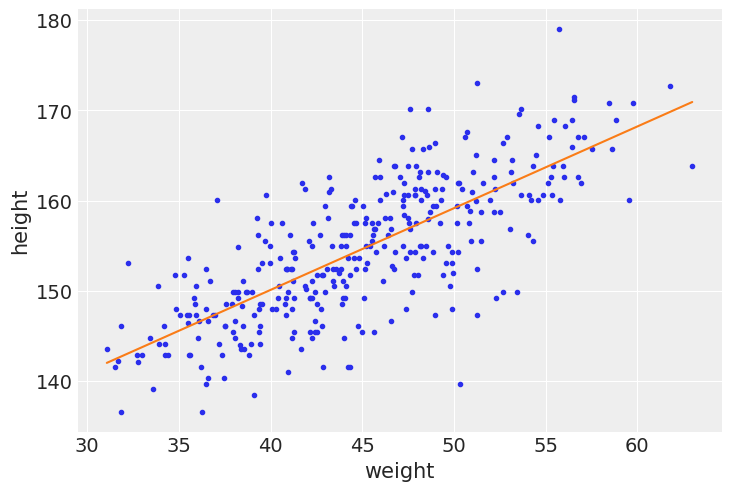

In [139]:
az.plot_pair(d2[['weight', 'height']].to_dict(orient='list'))
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
a_map = jnp.mean(post['a'])
b_map = jnp.mean(post['b'])
x = jnp.linspace(d2.weight.min(), d2.weight.max(), 101)
plt.plot(x, a_map + b_map * (x-xbar))
plt.show()


In [142]:
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))

In [149]:
{latent: list(post[latent].reshape(-1)[:5]) for latent in post}

{'a': [154.36615, 154.78511, 154.73534, 154.53842, 154.53549],
 'b': [0.974645, 0.8900049, 0.81902206, 0.8334104, 1.0119178],
 'mu': [157.12938, 146.0771, 141.5733, 162.21344, 150.74669],
 'sigma': [4.976459, 4.943529, 5.2826033, 4.877721, 4.894869]}

In [150]:
N = 10
dN = d2[:N]


def model(weight, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b = numpyro.sample("b", dist.LogNormal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = a + b * (weight - jnp.mean(weight))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


mN = AutoLaplaceApproximation(model)
svi = SVI(
    model, mN, optim.Adam(1), Trace_ELBO(), weight=dN.weight.values, height=dN.height.values
)
pN, losses = svi.run(random.PRNGKey(0), 1000)

100%|██████████| 1000/1000 [00:02<00:00, 452.48it/s, init loss: 1233.4979, avg. loss [951-1000]: 37.0481]


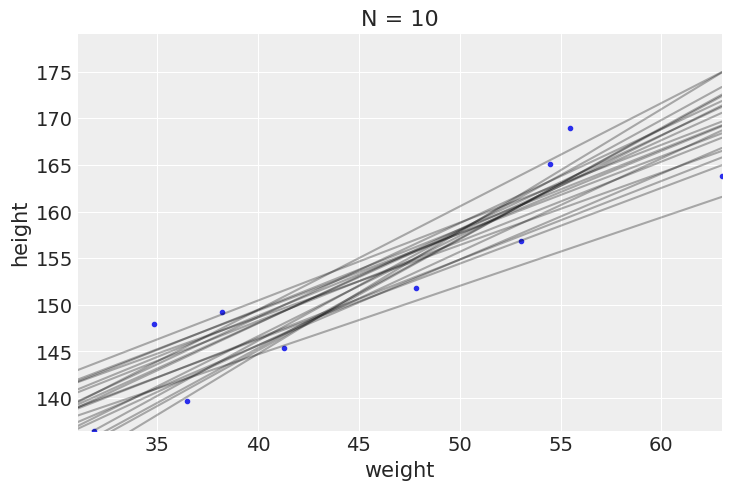

In [151]:
# extract 20 samples from the posterior
post = mN.sample_posterior(random.PRNGKey(1), pN, (20,))

# display raw data and sample size
ax = az.plot_pair(dN[["weight", "height"]].to_dict(orient="list"))
ax.set(
    xlim=(d2.weight.min(), d2.weight.max()),
    ylim=(d2.height.min(), d2.height.max()),
    title="N = {}".format(N),
)

# plot the lines, with transparency
x = jnp.linspace(d2.weight.min(), d2.weight.max(), 101)
for i in range(20):
    plt.plot(x, post["a"][i] + post["b"][i] * (x - dN.weight.mean()), "k", alpha=0.3)

In [152]:
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
mu_at_50 = post["a"] + post["b"] * (50 - xbar)

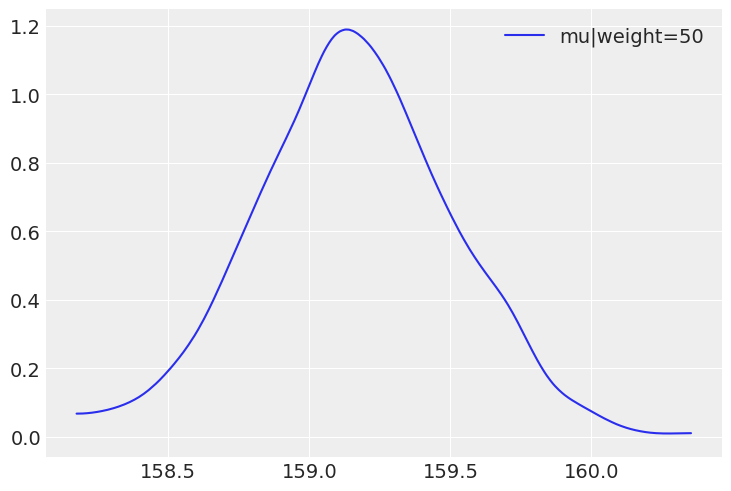

In [153]:
az.plot_kde(mu_at_50, label="mu|weight=50")
plt.show()

In [156]:
jnp.percentile(mu_at_50, [5.5, 94])

Buffer([158.5957 , 159.70676], dtype=float32)

In [157]:
mu = Predictive(m4_3.model, post, return_sites=["mu"])(
    random.PRNGKey(2), d2.weight.values, d2.height.values
)["mu"]
mu.shape, list(mu[:5, 0])

((1000, 352), [157.12938, 157.30838, 157.05736, 156.90125, 157.4044])

In [158]:
# define sequence of weights to compute predictions for
# these values will be on the horizontal axis
weight_seq = jnp.arange(start=25, stop=71, step=1)

# use predictive to compute mu
# for each sample from posterior
# and for each weight in weight_seq
mu = Predictive(m4_3.model, post, return_sites=["mu"])(
    random.PRNGKey(2), weight_seq, None
)["mu"]
mu.shape, list(mu[:5, 0])

((1000, 46), [134.88252, 136.99348, 138.36269, 137.87814, 134.30676])

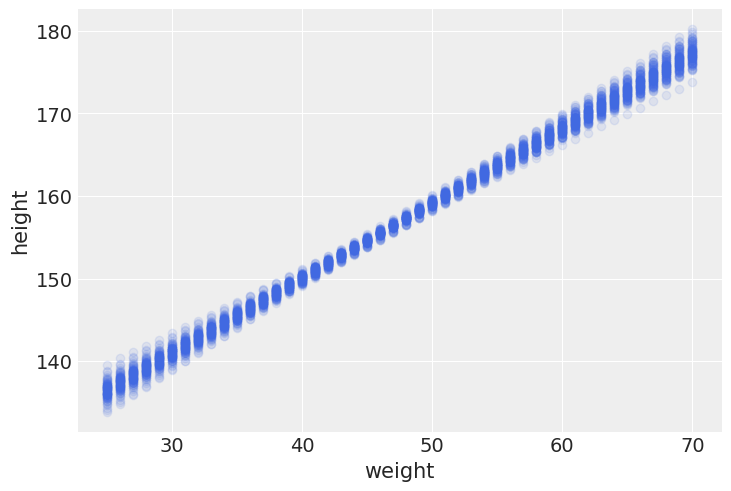

In [161]:
# use scatter_kwargs={"alpha": 0} to hide raw data
az.plot_pair(
    d2[["weight", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0}
)

# loop over samples and plot each mu value
for i in range(100):
    plt.plot(weight_seq, mu[i], "o", c="royalblue", alpha=0.1)

In [162]:
# summarize the distribution of mu
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=(5.5, 94.5), axis=0)

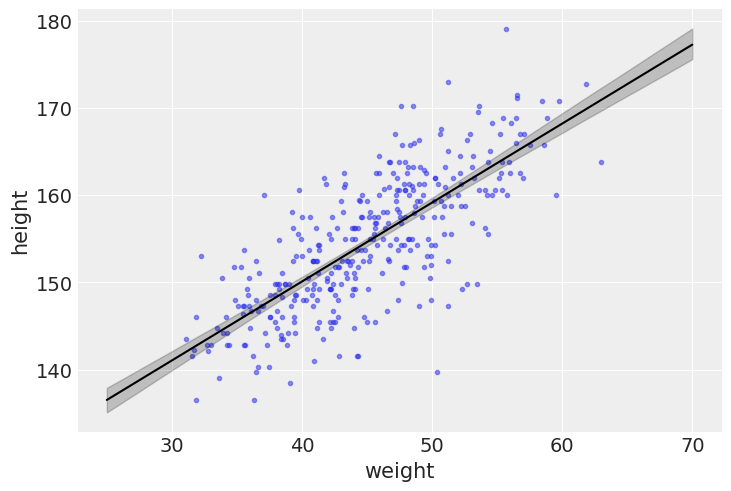

In [163]:
# plot raw data
# fading out points to make line and interval more visible
az.plot_pair(
    d2[["weight", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0.5}
)

# plot the MAP line, aka the mean mu for each weight
plt.plot(weight_seq, mu_mean, "k")

# plot a shaded region for 89% PI
plt.fill_between(weight_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
plt.show()

1. generate distirbution of posteriors
1. use summary function to get mean and lower boundds
1. use plotting functon to darw out lines and interval

In [165]:
mu_PI[0]

DeviceArray([135.08698, 136.04176, 137.00163, 137.97308, 138.94916,
             139.91855, 140.87654, 141.84944, 142.8079 , 143.78815,
             144.757  , 145.7285 , 146.68053, 147.62679, 148.57896,
             149.52205, 150.47641, 151.41951, 152.3567 , 153.26152,
             154.18149, 155.07791, 155.96138, 156.85262, 157.72363,
             158.5957 , 159.45923, 160.33806, 161.19484, 162.05424,
             162.92712, 163.77315, 164.6199 , 165.46143, 166.305  ,
             167.14659, 168.00763, 168.86089, 169.69896, 170.55197,
             171.392  , 172.22789, 173.07329, 173.91153, 174.75435,
             175.60542], dtype=float32)

In [167]:
d["weight_s"] = (d.weight - d.weight.mean()) / d.weight.std()
d["weight_s2"] = d.weight_s ** 2

d["weight_s3"] = d.weight_s ** 3


def model(weight_s, weight_s2, weight_s3, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b1 = numpyro.sample("b1", dist.LogNormal(0, 1))
    b2 = numpyro.sample("b2", dist.Normal(0, 1))
    b3 = numpyro.sample("b3", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = a + b1 * weight_s + b2 * weight_s2 + b3 * weight_s3
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


m4_6 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m4_6,
    optim.Adam(0.3),
    Trace_ELBO(),
    weight_s=d.weight_s.values,
    weight_s2=d.weight_s2.values,
    weight_s3=d.weight_s3.values,
    height=d.height.values,
)
p4_6, losses = svi.run(random.PRNGKey(0), 1000)

100%|██████████| 1000/1000 [00:01<00:00, 606.27it/s, init loss: 5544.0444, avg. loss [951-1000]: 1669.7249] 


In [170]:
d["weight_s"] = (d.weight - d.weight.mean()) / d.weight.std()
d["weight_s2"] = d.weight_s ** 2


def model(weight_s, weight_s2, height=None):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b1 = numpyro.sample("b1", dist.LogNormal(0, 1))
    b2 = numpyro.sample("b2", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", a + b1 * weight_s + b2 * weight_s2)
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


m4_5 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m4_5,
    optim.Adam(0.3),
    Trace_ELBO(),
    weight_s=d.weight_s.values,
    weight_s2=d.weight_s2.values,
    height=d.height.values,
)
p4_5, losses = svi.run(random.PRNGKey(0), 3000)

100%|██████████| 3000/3000 [00:04<00:00, 745.32it/s, init loss: 68267.6484, avg. loss [2851-3000]: 1770.2694] 


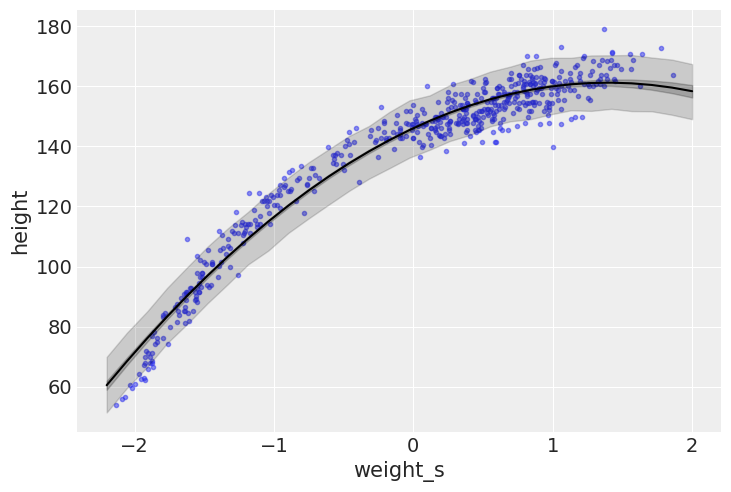

In [171]:
weight_seq = jnp.linspace(start=-2.2, stop=2, num=30)
pred_dat = {"weight_s": weight_seq, "weight_s2": weight_seq ** 2}
post = m4_5.sample_posterior(random.PRNGKey(1), p4_5, (1000,))
predictive = Predictive(m4_5.model, post)
mu = predictive(random.PRNGKey(2), **pred_dat)["mu"]
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=(5.5, 94.5), axis=0)
sim_height = predictive(random.PRNGKey(3), **pred_dat)["height"]
height_PI = jnp.percentile(sim_height, q=(5.5, 94.5), axis=0)
az.plot_pair(
    d[["weight_s", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0.5}
)
plt.plot(weight_seq, mu_mean, "k")
plt.fill_between(weight_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
plt.fill_between(weight_seq, height_PI[0], height_PI[1], color="k", alpha=0.15)
plt.show()

# 4.7 Practice

4E1.

The prior is 
$$
y \sim Normal(\mu, \sigma)
$$

The second line is prior, and the third one is prior

4E2: 
there are 2 parameters - $\mu$ and the $\sigma$

4E3

$$

p(\mu, \sigma | y) = Pr(\mu) * Pr(\sigma) * Pr(y|\mu, \sigma) / Pr(y)

$$

4E4

$$
\mu_{i} = \alpha + \beta x_{i}
$$
is the linear model

4E5
There is alpha, beta, and sigma. mu can be determined by alpha and beta


4 M1 and M2

In [174]:

#mu = numpyro.sample("mu", dist.Normal(0, 10))
#sigma = numpyro.sample("sigma", dist.Exponential(1))

4M3

$$

y \sim Normal(\mu, \sigma) \\
\mu = \alpha + \beta * x \\
\alpha \sim Normal(0, 10) \\
\beta \sim Uniform(0, 1) \\
\sigma \sim Exponential(1)

$$

4M4

$$

let h = height
let y = year
h \sim Normal(\mu, \sigma) \\
\mu = \alpha + \beta * y \\
\alpha \sim Normal(0, 100) \\
\beta \sim Normal(0, 10) \\
\sigma \sim Uniforma(0, 50)
$$

6M6
In this case, i woudl change the vaiance of sigma to be uniform from 0 to 64(64 being the upper bound)

4H1

In [178]:
d = df[df.age <=18]

In [179]:
# define the average weight, x-bar
xbar = d2.weight.mean()

# fit model
def model(weight, height):
    a = numpyro.sample("a", dist.Normal(100, 100))
    b = numpyro.sample("b", dist.LogNormal(0, 10))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", a + b * (weight - xbar))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


m4_3 = AutoLaplaceApproximation(model)
svi = SVI(
    model, m4_3, optim.Adam(1), Trace_ELBO(), weight=d.weight.values, height=d.height.values
)
p4_3, losses = svi.run(random.PRNGKey(0), 2000)

100%|██████████| 2000/2000 [00:03<00:00, 574.68it/s, init loss: 61884.2539, avg. loss [1901-2000]: 987.7645] 


In [180]:
samples = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
samples.pop("mu")
print_summary(samples, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a    109.90      0.00    109.90    109.90    109.90      0.50      1.00
         b      0.01      0.00      0.01      0.01      0.01      0.50      1.00
     sigma     46.21      0.00     46.21     46.21     46.21      0.50       nan

